# Trabalho 1 — INF-0618 Deep Learning   


Para este trabalho, utilizaremos a base de dados DermaMNIST, composta de 10.015 imagens (7.007 de treino, 1.003 de validação e 2.005 de teste) subdivididas em 7 classes.

Cada amostra do dado está associada a exatamente um dos seguintes rótulos:
- *actinic keratoses and intraepithelial carcinoma* (0)
- *basal cell carcinoma* (1)
- *benign keratosis-like lesions* (2)
- *dermatofibroma* (3)
- *melanoma* (4)
- *melanocytic nevi* (5)
- *vascular lesions* (6)

<img src="https://medmnist.com/assets/v2/imgs/DermaMNIST.jpg" />

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

# Running in SaturnCloud

## *Download* dos dados

Utilizaremos da bibilioteca curl para baixar a base de dados DermaMNIST. Usaremos o comando da seguinte forma

```
curl -o nome_do_arquivo link_para_download
```


In [1]:
!curl -o dermamnist.npz https://zenodo.org/records/10519652/files/dermamnist.npz?download=1

curl: /opt/saturncloud/envs/saturn/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:02:44 --:--:--     0^C


## Carregando os dados

In [1]:
import numpy as np

In [2]:
# Carrega a base de dados
dermamnist = np.load("./dermamnist.npz") # O arquivo chama-se dermamnist.npz (definido no curl)

# Separa em conjuntos de treino, validacao e teste
x_train = dermamnist["train_images"]
y_train = dermamnist["train_labels"]

x_val = dermamnist["val_images"]
y_val = dermamnist["val_labels"]

x_test = dermamnist["test_images"]
y_test = dermamnist["test_labels"]

In [3]:
# para visualizar os dados, utilizaremos a biblioteca matplotlib
from matplotlib import pyplot as plt

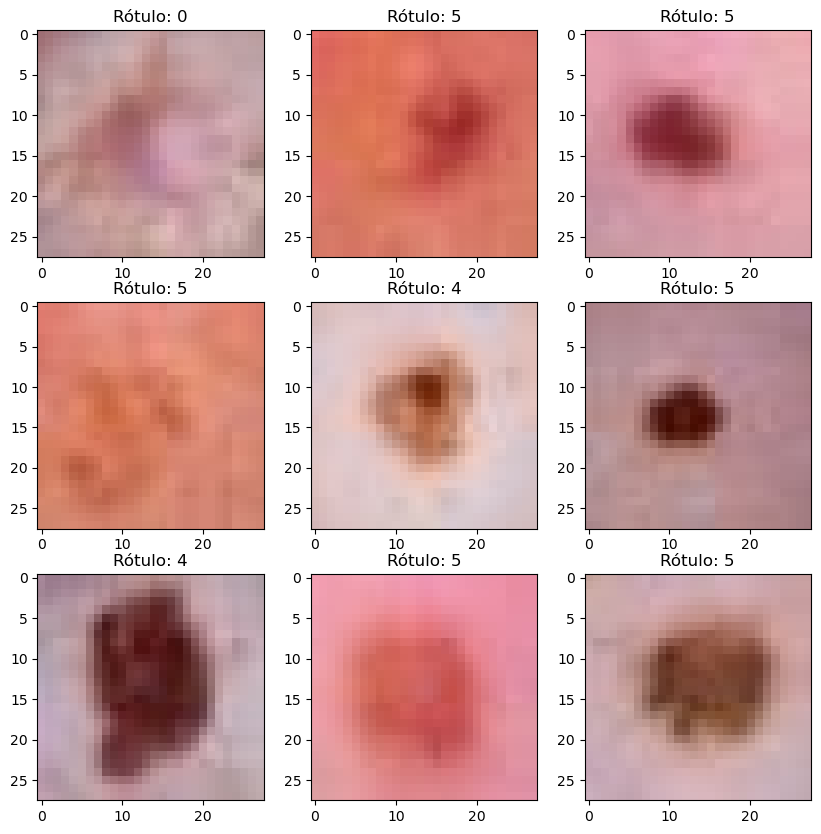

In [6]:
fig, ax = plt.subplots(figsize=(10,10), ncols=3, nrows=3)
sample = 0
for i in range(3):
    for j in range(3):
        imagem = x_train[sample]
        ax[i][j].imshow(imagem)
        rotulo = y_train[sample][0]
        ax[i][j].title.set_text(f"Rótulo: {rotulo}")
        sample += 1

## Preparação dos dados

In [7]:
!pip install visualkeras

  Using cached visualkeras-0.0.2-py3-none-any.whl.metadata (5.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 15.8 MB/s eta 0:00:00 0:00:01


In [9]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 112.1 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 67.9 MB/s eta 0:00:00:00:0100:01


In [4]:
import os

import visualkeras

import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

2024-05-19 19:13:54.916572: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 19:13:54.962334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 19:13:54.962367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 19:13:54.963524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 19:13:54.970996: I tensorflow/core/platform/cpu_feature_guar

In [5]:
x_train.shape

(7007, 28, 28, 3)

In [6]:
y_train.shape

(7007, 1)

In [7]:
# Ajustando o formato da variavel y para one-hot encoding
n_classes = 7

y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val_ohe = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

In [8]:
# Checando a distribuicao das classes
unique, counts = np.unique(y_train, return_counts=True)
print( "Treino:", dict(zip(unique, counts)) )

Treino: {0: 228, 1: 359, 2: 769, 3: 80, 4: 779, 5: 4693, 6: 99}


In [9]:
y_train.reshape(-1).shape

(7007,)

In [10]:
# Nossos dados de treinamento estao desbalanceados
# Vamos testar o desenvolvimento a seguir utilizando o balanceamento das classes via pesos
# (Caso necessario mudaremos a estrategia posteriormente)

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_train.reshape(-1)),
                                     y=y_train.reshape(-1))
train_class_weights = dict(enumerate(class_weights))

train_class_weights

{0: 4.390350877192983,
 1: 2.788300835654596,
 2: 1.3016905071521456,
 3: 12.5125,
 4: 1.2849807445442876,
 5: 0.21329639889196675,
 6: 10.11111111111111}

In [11]:
# Normalizando os dados
x_train_norm = x_train / 255.0
x_val_norm = x_val / 255.0
x_test_norm = x_test / 255.0

In [12]:
x_train_norm[0]

array([[[0.61960784, 0.43529412, 0.45882353],
        [0.63137255, 0.45490196, 0.4745098 ],
        [0.64313725, 0.4745098 , 0.50980392],
        ...,
        [0.74117647, 0.62745098, 0.64313725],
        [0.73333333, 0.61960784, 0.62745098],
        [0.72941176, 0.61568627, 0.62352941]],

       [[0.62745098, 0.44313725, 0.46666667],
        [0.64705882, 0.47058824, 0.49019608],
        [0.66666667, 0.50588235, 0.5372549 ],
        ...,
        [0.74901961, 0.63529412, 0.65098039],
        [0.74117647, 0.62745098, 0.63529412],
        [0.7372549 , 0.62352941, 0.63137255]],

       [[0.64313725, 0.46666667, 0.48627451],
        [0.66666667, 0.50196078, 0.51764706],
        [0.69411765, 0.5372549 , 0.56862745],
        ...,
        [0.74901961, 0.63529412, 0.65098039],
        [0.7372549 , 0.63529412, 0.64705882],
        [0.73333333, 0.63137255, 0.64313725]],

       ...,

       [[0.6745098 , 0.55686275, 0.58823529],
        [0.69019608, 0.57647059, 0.59607843],
        [0.71372549, 0

## Modelo baseline

In [13]:
x_train_norm.shape[1:]

(28, 28, 3)

In [14]:
INPUT_SHAPE = x_train_norm.shape[1:]

### Training the model WITH class weights

In [21]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=12,
                           kernel_size=(3, 3),
                           strides=(1, 1),
                           padding="valid",
                           data_format=None,
                           dilation_rate=(1, 1),
                           groups=1,
                           activation="relu",
                           use_bias=True,
                           kernel_initializer="glorot_uniform",
                           bias_initializer="zeros",
                           kernel_regularizer=None,
                           bias_regularizer=None,
                           activity_regularizer=None,
                           kernel_constraint=None,
                           bias_constraint=None,
                           input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
])

baseline_model.summary()

2024-05-19 18:46:35.247318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 18:46:35.293984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 18:46:35.294236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 12)        336       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 12)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2028)              0         
                                                                 
 dense (Dense)               (None, 7)                 14203     
                                                                 
Total params: 14539 (56.79 KB)
Trainable params: 14539 (56.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


L355
2024-05-19 18:46:35.295424: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 18:46:35.295573: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 18:46:35.412647: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

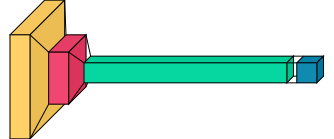

In [22]:
visualkeras.layered_view(baseline_model)

In [26]:
# Compilando o modelo baseline
baseline_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                       metrics=["accuracy"])

In [27]:
# model_path = "/content/drive/MyDrive/Colab Notebooks/mineracao_dados_complexos/mdc/08_deep_learning/test01/artefatos/"
model_path = "./artefatos/"
model_name = "baseline_with_class_weights_model.h5"

model_path_full = os.path.join(model_path, model_name)
model_path_full

'./artefatos/baseline_with_class_weights_model.h5'

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
baseline_model.fit( x_train_norm, y_train_ohe,
                    epochs=300,
                    batch_size=128,
                    validation_data=(x_val_norm, y_val_ohe),
                    verbose=1,
                    class_weight=train_class_weights,
                    callbacks=[# early_stopping,
                               model_checkpoint])

Epoch 1/300


2024-05-19 18:48:23.058175: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-19 18:48:23.186746: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-19 18:48:23.363605: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f729cfd04f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-19 18:48:23.363673: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-19 18:48:23.383341: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
I0000 00:00:1716144503.433622    2112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 [==============================] - 2s 9ms/step - loss: 1.9553 - accuracy: 0.5255 - val_loss: 1.8886 - val_accuracy: 0.3679
Epoch 2/300
54/55 [============================>.] - ETA: 0s - loss: 1.9406 - accuracy: 0.2147

/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 0s 4ms/step - loss: 1.9462 - accuracy: 0.2149 - val_loss: 1.9222 - val_accuracy: 0.2672
Epoch 3/300
55/55 [==============================] - 0s 4ms/step - loss: 1.9430 - accuracy: 0.2082 - val_loss: 1.9366 - val_accuracy: 0.1216
Epoch 4/300
55/55 [==============================] - 0s 4ms/step - loss: 1.9400 - accuracy: 0.1120 - val_loss: 1.9189 - val_accuracy: 0.1186
Epoch 5/300
55/55 [==============================] - 0s 4ms/step - loss: 1.9385 - accuracy: 0.1330 - val_loss: 1.9289 - val_accuracy: 0.1246
Epoch 6/300
55/55 [==============================] - 0s 4ms/step - loss: 1.9356 - accuracy: 0.0746 - val_loss: 1.9197 - val_accuracy: 0.2981
Epoch 7/300
55/55 [==============================] - 0s 4ms/step - loss: 1.9335 - accuracy: 0.3302 - val_loss: 1.9320 - val_accuracy: 0.1167
Epoch 8/300
55/55 [==============================] - 0s 4ms/step - loss: 1.9313 - accuracy: 0.2246 - val_loss: 1.9241 - val_accuracy: 0.1486
Epoch 9/300
55/55 [======

In [15]:
def plot_loss_values(history):
    plt.figure(figsize=(10, 5))

    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")

    plt.legend()
    plt.show()

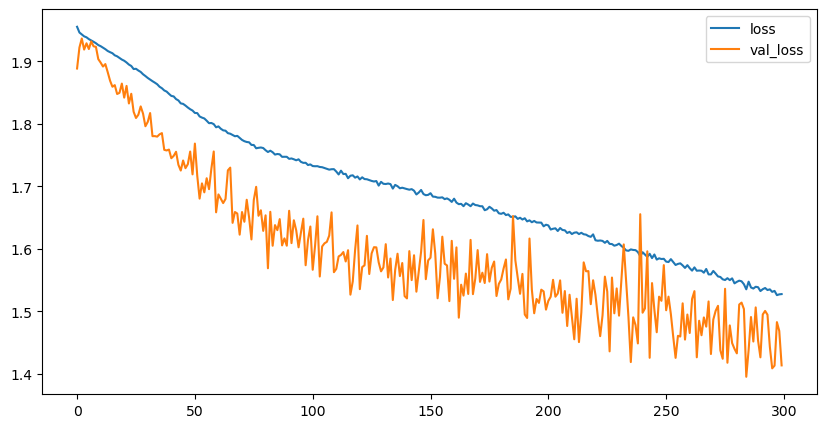

In [30]:
plot_loss_values(baseline_model.history.history)

In [16]:
def print_accuracy_and_loss(model, name, description, data_type,
                            xval=x_val_norm, yval=y_val_ohe): # x_val_norm, y_val_ohe

    loss, acc = model.evaluate(xval, yval)

    validation_results = {
        "model": {
            "data": data_type,
            "name": name,
            "description": description,
            "loss": loss,
            "accuracy": acc
        }
    }

    print(validation_results)

In [32]:
path_full = os.path.join(model_path, "baseline_with_class_weights_model.h5")
baseline_model = tf.keras.models.load_model(path_full) # Loading the best model trained

print_accuracy_and_loss(baseline_model,
                        "baseline_with_class_weights",
                        "Modelo baseline com pesos de classes ajustados",
                        "validation")

32/32 [==============================] - 0s 3ms/step - loss: 1.3954 - accuracy: 0.4865
{'model': {'data': 'validation', 'name': 'baseline_with_class_weights', 'description': 'Modelo baseline com pesos de classes ajustados', 'loss': 1.395409345626831, 'accuracy': 0.48654037714004517}}


### Training the model WITHOUT class weights

In [34]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=12,
                           kernel_size=(3, 3),
                           strides=(1, 1),
                           padding="valid",
                           data_format=None,
                           dilation_rate=(1, 1),
                           groups=1,
                           activation="relu",
                           use_bias=True,
                           kernel_initializer="glorot_uniform",
                           bias_initializer="zeros",
                           kernel_regularizer=None,
                           bias_regularizer=None,
                           activity_regularizer=None,
                           kernel_constraint=None,
                           bias_constraint=None,
                           input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
])

# Compilando o modelo baseline
baseline_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                       metrics=["accuracy"])

model_name = "baseline_model.h5"
model_path_full = os.path.join(model_path, model_name)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
baseline_model.fit( x_train_norm, y_train_ohe,
                    epochs=300,
                    batch_size=128,
                    validation_data=(x_val_norm, y_val_ohe),
                    verbose=1,
                    # class_weight=train_class_weights,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/300
55/55 [==============================] - 1s 6ms/step - loss: 1.3480 - accuracy: 0.6070 - val_loss: 1.1702 - val_accuracy: 0.6690
Epoch 2/300
55/55 [==============================] - 0s 4ms/step - loss: 1.1594 - accuracy: 0.6698 - val_loss: 1.1475 - val_accuracy: 0.6690
Epoch 3/300
55/55 [==============================] - 0s 3ms/step - loss: 1.1440 - accuracy: 0.6698 - val_loss: 1.1376 - val_accuracy: 0.6690
Epoch 4/300
55/55 [==============================] - 0s 4ms/step - loss: 1.1363 - accuracy: 0.6698 - val_loss: 1.1322 - val_accuracy: 0.6690
Epoch 5/300
55/55 [==============================] - 0s 3ms/step - loss: 1.1317 - accuracy: 0.6698 - val_loss: 1.1285 - val_accuracy: 0.6690
Epoch 6/300
55/55 [==============================] - 0s 4ms/step - loss: 1.1279 - accuracy: 0.6698 - val_loss: 1.1252 - val_accuracy: 0.6690
Epoch 7/300
55/55 [==============================] - 0s 4ms/step - loss: 1.1249 - accuracy: 0.6698 - val_loss: 1.1226 - val_accuracy: 0.6690
Epoch 8/300
5

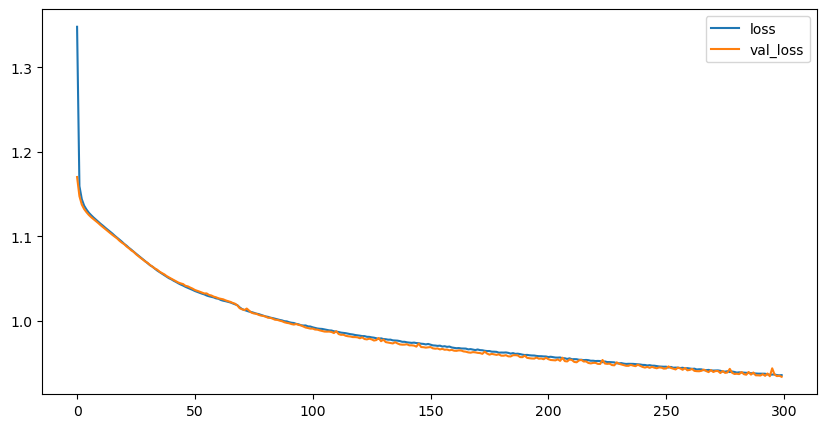

In [35]:
plot_loss_values(baseline_model.history.history)

In [36]:
model_path_full

'./artefatos/baseline_model.h5'

In [37]:
path_full = os.path.join(model_path, "baseline_model.h5")
baseline_model = tf.keras.models.load_model(path_full)

print_accuracy_and_loss(baseline_model,
                        "baseline_without_class_weights",
                        "Modelo baseline SEM pesos de classes ajustados",
                        "validation")

32/32 [==============================] - 0s 2ms/step - loss: 0.9338 - accuracy: 0.6810
{'model': {'data': 'validation', 'name': 'baseline_without_class_weights', 'description': 'Modelo baseline SEM pesos de classes ajustados', 'loss': 0.9337608218193054, 'accuracy': 0.6809571385383606}}


### Exploring variations of the baseline model

In [38]:
INPUT_SHAPE

(28, 28, 3)

#### Variation 1 (Best baseline model)

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=12,
                           kernel_size=(3, 3),
                           strides=(1, 1),
                           padding="valid",
                           activation="relu",
                           input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(2, 2),
                           strides=(1, 1),
                           padding="valid",
                           activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=28,
                          activation="relu"),

    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
    ])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 12)        336       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 12)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 13, 13, 12)        48        
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 6)         294       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 6)           0         
 g2D)                                                            
                                                      

In [40]:
model.compile(  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"])

In [41]:
model_path

'./artefatos/'

In [42]:
model_name = "baseline_model_variation_N1.h5"

model_path_full = os.path.join(model_path, model_name)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
model.fit(          x_train_norm, y_train_ohe,
                    epochs=300,
                    batch_size=128,
                    validation_data=(x_val_norm, y_val_ohe),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/300
55/55 [==============================] - 2s 9ms/step - loss: 1.8024 - accuracy: 0.3665 - val_loss: 1.6312 - val_accuracy: 0.6660
Epoch 2/300
55/55 [==============================] - 0s 5ms/step - loss: 1.4685 - accuracy: 0.5707 - val_loss: 1.5246 - val_accuracy: 0.6670
Epoch 3/300
55/55 [==============================] - 0s 5ms/step - loss: 1.3397 - accuracy: 0.6232 - val_loss: 1.4440 - val_accuracy: 0.6530
Epoch 4/300
55/55 [==============================] - 0s 5ms/step - loss: 1.2674 - accuracy: 0.6398 - val_loss: 1.3726 - val_accuracy: 0.6431
Epoch 5/300
55/55 [==============================] - 0s 5ms/step - loss: 1.2161 - accuracy: 0.6478 - val_loss: 1.2950 - val_accuracy: 0.6540
Epoch 6/300
55/55 [==============================] - 0s 5ms/step - loss: 1.1793 - accuracy: 0.6513 - val_loss: 1.2143 - val_accuracy: 0.6630
Epoch 7/300
55/55 [==============================] - 0s 5ms/step - loss: 1.1478 - accuracy: 0.6549 - val_loss: 1.1525 - val_accuracy: 0.6680
Epoch 8/300
5

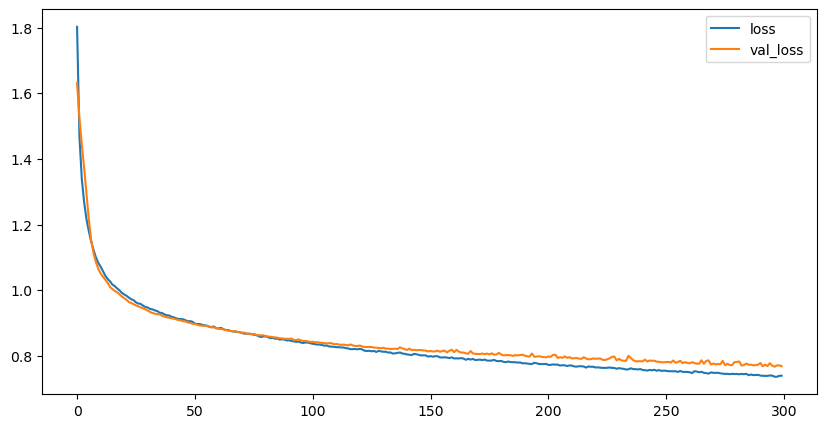

In [43]:
plot_loss_values(model.history.history)

In [44]:
path_full = os.path.join(model_path, "baseline_model_variation_N1.h5")
model_N1 = tf.keras.models.load_model(path_full)

print_accuracy_and_loss(model_N1,
                        "baseline_variation_N1",
                        "Primeira variacao do modelo baseline",
                        "validation")

32/32 [==============================] - 0s 3ms/step - loss: 0.7673 - accuracy: 0.7248
{'model': {'data': 'validation', 'name': 'baseline_variation_N1', 'description': 'Primeira variacao do modelo baseline', 'loss': 0.7672799229621887, 'accuracy': 0.7248255014419556}}


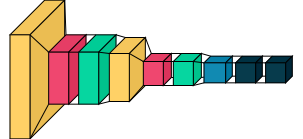

In [45]:
visualkeras.layered_view(model_N1)

#### Variation 2

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=12,
                           kernel_size=(3, 3),
                           strides=(1, 1),
                           padding="valid",
                           activation="relu",
                           input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(2, 2),
                           strides=(1, 1),
                           padding="valid",
                           activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=28,
                          activation="relu"),
    tf.keras.layers.Dropout(rate=0.25), # New
    tf.keras.layers.Dense(units=28,
                          activation="relu"),
    tf.keras.layers.Dropout(rate=0.25), # New

    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
    ])

model.compile(  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"])

model_name = "baseline_model_variation_N2.h5"

model_path_full = os.path.join(model_path, model_name)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
model.fit(          x_train_norm, y_train_ohe,
                    epochs=300,
                    batch_size=128,
                    validation_data=(x_val_norm, y_val_ohe),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/300
55/55 [==============================] - 1s 8ms/step - loss: 2.0893 - accuracy: 0.1454 - val_loss: 1.9311 - val_accuracy: 0.0837
Epoch 2/300
55/55 [==============================] - 0s 5ms/step - loss: 1.7897 - accuracy: 0.2466 - val_loss: 1.9047 - val_accuracy: 0.1087
Epoch 3/300
55/55 [==============================] - 0s 5ms/step - loss: 1.5889 - accuracy: 0.3875 - val_loss: 1.8281 - val_accuracy: 0.1755
Epoch 4/300
55/55 [==============================] - 0s 5ms/step - loss: 1.4862 - accuracy: 0.4545 - val_loss: 1.7111 - val_accuracy: 0.2832
Epoch 5/300
55/55 [==============================] - 0s 5ms/step - loss: 1.3829 - accuracy: 0.5165 - val_loss: 1.5722 - val_accuracy: 0.5274
Epoch 6/300
55/55 [==============================] - 0s 5ms/step - loss: 1.3288 - accuracy: 0.5506 - val_loss: 1.4101 - val_accuracy: 0.6471
Epoch 7/300
55/55 [==============================] - 0s 5ms/step - loss: 1.2819 - accuracy: 0.5787 - val_loss: 1.2664 - val_accuracy: 0.6650
Epoch 8/300
5

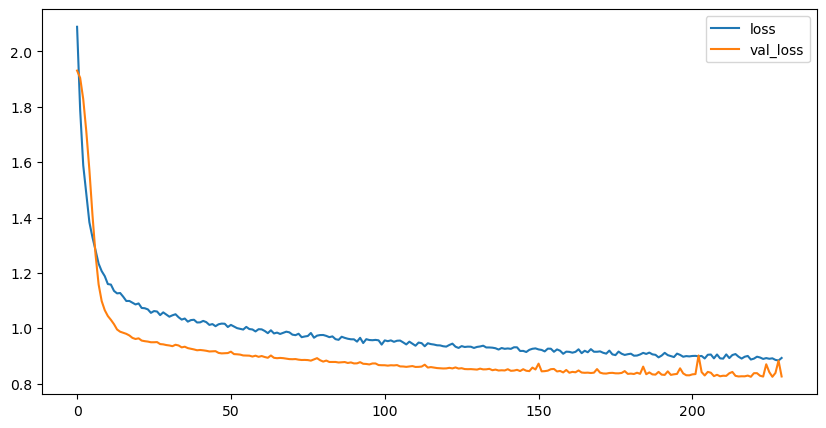

In [48]:
plot_loss_values(model.history.history)

In [49]:
path_full = os.path.join(model_path, "baseline_model_variation_N2.h5")
model_N2 = tf.keras.models.load_model(path_full)

print_accuracy_and_loss(model_N2,
                        "baseline_variation_N2",
                        "Segunda variacao do modelo baseline",
                        "validation")

# Por enquanto o melhor modelo foi a variação N1 do modelo baseline, com os seguintes resultados:
# {
#     'model': {
#         'data': 'validation', 
#         'name': 'baseline_variation_N1', 
#         'description': 'Primeira variacao do modelo baseline', 
#         'loss': 0.7672799229621887, 
#         'accuracy': 0.7248255014419556
#     }
# }

32/32 [==============================] - 0s 2ms/step - loss: 0.8245 - accuracy: 0.6959
{'model': {'data': 'validation', 'name': 'baseline_variation_N2', 'description': 'Segunda variacao do modelo baseline', 'loss': 0.8245439529418945, 'accuracy': 0.69591224193573}}


## Transfer-learning com fine-tuning da rede (Congelamento das camadas e adição de camada de saída)

In [17]:
pre_trained_model = tf.keras.applications.InceptionResNetV2(weights="imagenet",
                                                            include_top=False,
                                                            input_shape=(75, 75, 3))

for layer in pre_trained_model.layers:
    layer.trainable = False

2024-05-19 19:15:28.039788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 19:15:28.086899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 19:15:28.087149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [31]:
adapted_inception_model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16,
                          activation="relu"),
    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
])

adapted_inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1, 1, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                24592     
                                                                 
 dense_3 (Dense)             (None, 7)                 119       
                                                                 
Total params: 54361447 (207.37 MB)
Trainable params: 2

In [91]:
# pre_trained_model.summary()

# Total params: 54336736 (207.28 MB)
# Trainable params: 54276192 (207.05 MB)
# Non-trainable params: 60544 (236.50 KB)_________________________________

In [52]:
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 95.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 25.9 MB/s eta 0:00:00


In [67]:
!python -m pip install scipy

In [19]:
from skimage.transform import resize

In [20]:
# Redimensionando as imagens para estarem no mesmo formato que a rede base usa
new_shape = (75, 75, 3)

def resize_images(images, new_shape=new_shape):

    resized_images = np.empty(shape=(images.shape[0],) + new_shape)
    for idx in range(images.shape[0]):
        resized_images[idx] = resize(images[idx], new_shape)

    print( images.shape, resized_images.shape )

    return resized_images

In [21]:
x_train_resized = resize_images(x_train)
x_val_resized = resize_images(x_val)
x_test_resized = resize_images(x_test)

(7007, 28, 28, 3) (7007, 75, 75, 3)
(1003, 28, 28, 3) (1003, 75, 75, 3)
(2005, 28, 28, 3) (2005, 75, 75, 3)


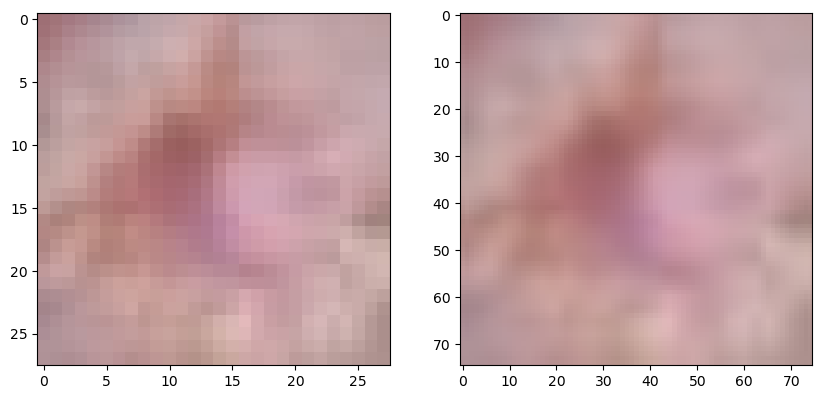

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(x_train[0])
ax[1].imshow(x_train_resized[0])

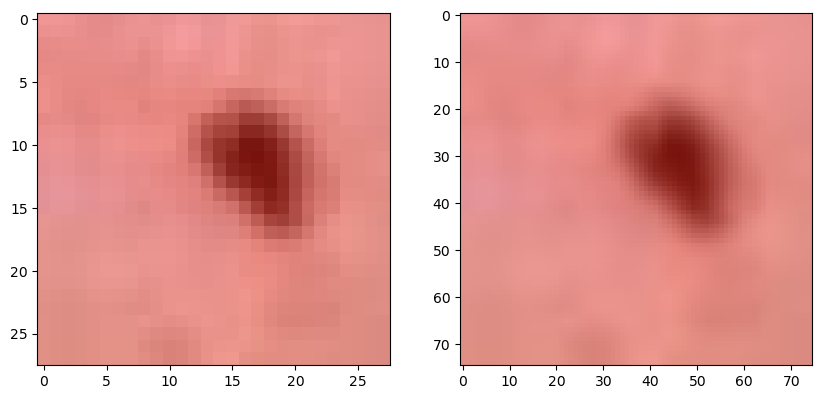

In [23]:
fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(x_val[0])
ax[1].imshow(x_val_resized[0])

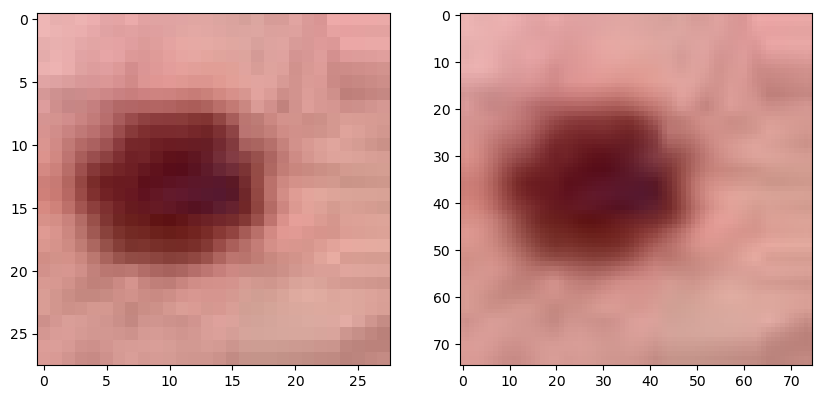

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(x_test[0])
ax[1].imshow(x_test_resized[0])

In [32]:
datagen_inception = tf.keras.preprocessing.image.ImageDataGenerator(
    
    # rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input
)

In [34]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=0.001)

# Batches de treino e validação
train_batches = datagen_inception.flow(x_train_resized, y_train_ohe, shuffle=True, batch_size=128)
val_batches = datagen_inception.flow(x_val_resized, y_val_ohe, shuffle=False, batch_size=128)

adapted_inception_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

In [35]:
# model_path = "/content/drive/MyDrive/Colab Notebooks/mineracao_dados_complexos/mdc/08_deep_learning/test01/artefatos/"
model_path = "./artefatos/"
model_name = "adapted_inception_model_finetunning.h5"
model_path_full = os.path.join(model_path, model_name)

model_path_full

'./artefatos/adapted_inception_model_finetunning.h5'

In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
adapted_inception_model.fit(train_batches,
                            epochs=30,
                            validation_data=val_batches,
                            verbose=1,
                            callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
55/55 [==============================] - 27s 318ms/step - loss: 1.4961 - accuracy: 0.6170 - val_loss: 1.3201 - val_accuracy: 0.6690
Epoch 2/30
55/55 [==============================] - 14s 249ms/step - loss: 1.2758 - accuracy: 0.6698 - val_loss: 1.2430 - val_accuracy: 0.6690
Epoch 3/30
55/55 [==============================] - 14s 248ms/step - loss: 1.2200 - accuracy: 0.6698 - val_loss: 1.2023 - val_accuracy: 0.6690
Epoch 4/30
55/55 [==============================] - 14s 249ms/step - loss: 1.1873 - accuracy: 0.6698 - val_loss: 1.1764 - val_accuracy: 0.6690
Epoch 5/30
55/55 [==============================] - 14s 249ms/step - loss: 1.1656 - accuracy: 0.6698 - val_loss: 1.1590 - val_accuracy: 0.6690
Epoch 6/30
55/55 [==============================] - 14s 249ms/step - loss: 1.1517 - accuracy: 0.6698 - val_loss: 1.1486 - val_accuracy: 0.6690
Epoch 7/30
55/55 [==============================] - 14s 247ms/step - loss: 1.1428 - accuracy: 0.6698 - val_loss: 1.1420 - val_accuracy: 0.6690

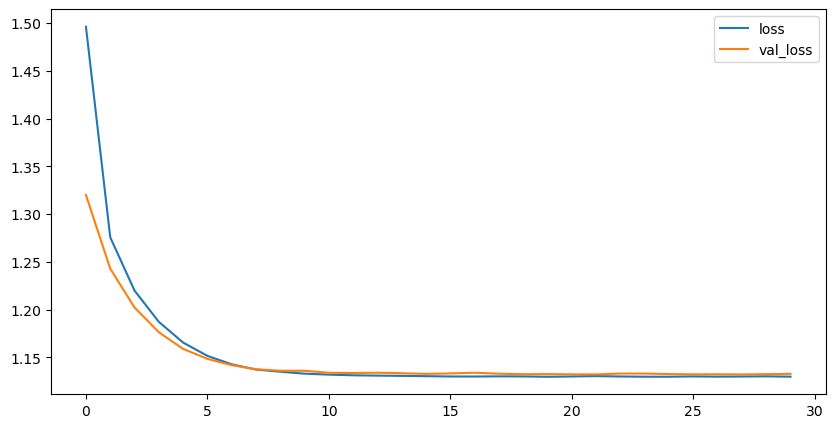

In [37]:
plot_loss_values(adapted_inception_model.history.history)

In [50]:
score = adapted_inception_model.evaluate(val_batches, verbose=1)
print('Val loss:', score[0])
print('Val acc:', score[1])

8/8 [==============================] - 2s 182ms/step - loss: 1.1322 - accuracy: 0.6690
Val loss: 1.1321706771850586
Val acc: 0.6689929962158203


In [42]:
model_path_full

'./artefatos/adapted_inception_model_finetunning.h5'

## Fine-tuning descongelando o modelo inteiro

In [44]:
pre_trained_model = tf.keras.applications.InceptionResNetV2(weights="imagenet",
                                                            include_top=False,
                                                            input_shape=(75, 75, 3))

for layer in pre_trained_model.layers:
    layer.trainable = True
    
finetuned_inception_model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
])

finetuned_inception_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1, 1, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 7)                 10759     
                                                                 
Total params: 54347495 (207.32 MB)
Trainable params: 54286951 (207.09 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


In [45]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=0.001)

# Batches de treino e validação
train_batches = datagen_inception.flow(x_train_resized, y_train_ohe, shuffle=True, batch_size=128)
val_batches = datagen_inception.flow(x_val_resized, y_val_ohe, shuffle=False, batch_size=128)

finetuned_inception_model.compile(loss="categorical_crossentropy", 
                                  optimizer=sgd, 
                                  metrics=["accuracy"])

In [46]:
# model_path = "/content/drive/MyDrive/Colab Notebooks/mineracao_dados_complexos/mdc/08_deep_learning/test01/artefatos/"
model_path = "./artefatos/"
model_name = "finetuned_inception_model.h5"
model_path_full = os.path.join(model_path, model_name)

model_path_full

'./artefatos/finetuned_inception_model.h5'

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
finetuned_inception_model.fit(train_batches,
                              epochs=30,
                              validation_data=val_batches,
                              verbose=1,
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
55/55 [==============================] - 72s 406ms/step - loss: 1.0968 - accuracy: 0.6317 - val_loss: 1.4682 - val_accuracy: 0.6690
Epoch 2/30
55/55 [==============================] - 17s 304ms/step - loss: 0.7913 - accuracy: 0.7169 - val_loss: 1.3711 - val_accuracy: 0.6690
Epoch 3/30
55/55 [==============================] - 17s 304ms/step - loss: 0.7403 - accuracy: 0.7247 - val_loss: 1.2593 - val_accuracy: 0.6690
Epoch 4/30
55/55 [==============================] - 17s 305ms/step - loss: 0.6994 - accuracy: 0.7351 - val_loss: 1.1783 - val_accuracy: 0.6690
Epoch 5/30
55/55 [==============================] - 13s 235ms/step - loss: 0.6760 - accuracy: 0.7483 - val_loss: 1.2643 - val_accuracy: 0.6690
Epoch 6/30
55/55 [==============================] - 13s 235ms/step - loss: 0.6516 - accuracy: 0.7628 - val_loss: 1.2901 - val_accuracy: 0.6690
Epoch 7/30
55/55 [==============================] - 13s 234ms/step - loss: 0.6338 - accuracy: 0.7637 - val_loss: 1.2135 - val_accuracy: 0.6690

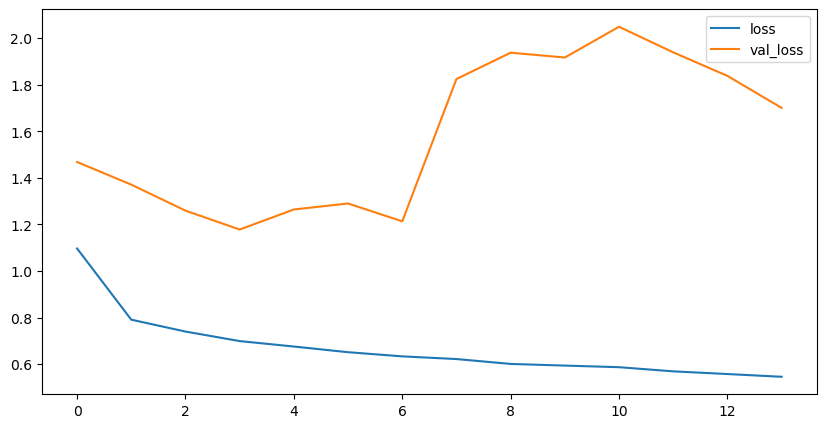

In [48]:
plot_loss_values(finetuned_inception_model.history.history)

In [51]:
score = finetuned_inception_model.evaluate(val_batches, verbose=1)
print('Val loss:', score[0])
print('Val acc:', score[1])

8/8 [==============================] - 2s 187ms/step - loss: 1.7102 - accuracy: 0.6690
Val loss: 1.7101536989212036
Val acc: 0.6689929962158203


## Resultados em validação

| Modelo | Acurácia (%) |
|--------|--------------|
| modelo baseline COM balanceamento de classes | 0.48654037714004517 |
| modelo baseline SEM balanceamento de classes | 0.6809571385383606 |
| modelo baseline (SEM balanceamento) - Variacao N1  | 0.7248255014419556 | 
| modelo baseline (SEM balanceamento) - Variacao N2 | 0.69591224193573 |
| transfer-learning com rede congelada + fine-tuning | 0.6689929962158203 |
| transfer-learning com descongelamento da rede + fine-tuning | 0.6689929962158203 |


*O melhor modelo obtido de acordo com as premissas seguidas foi o **modelo baseline (SEM balanceamento) - Variacao N1**.*

O fato de modelos mais robustos não terem performado tão bem nesse conjunto de dados pode estar relacionado a alguns fatores, como por exemplo 
- o número de épocas usadas ao treinar o modelo *transfer-learning com rede congelada + fine-tuning*
- o fato de o modelo *transfer-learning com descongelamento da rede + fine-tuning* ter claramente entrado em overfitting para o problema em questão
- os pesos utilizados não se adequarem bem para o problema em questão (segmento de dermatologia)
- a rede em si utilizada como base para o transfer-learning não se adequar bem para o problema que estamos buscando resolver

Algumas estratégias para driblar tais situações e obter um resultado melhor que o baseline podem ser seguidas posteriormente numa nova exploração, como mudar a rede pré-treinada utilizada como base, mudar as camadas de fine-tuning combinadas com o modelo pré-treinado, etc. Tais alternativas não garantem porém que teremos um resultado melhor, de modo que a investigação é necessária.

## Avaliando o melhor modelo (modelo baseline (SEM balanceamento) - Variacao N1) no conjunto de teste

| Modelo | Acurácia (%) |
|--------|--------------|
| modelo baseline (SEM balanceamento) - Variacao N1  | 0.7122194766998291 | 

In [52]:
path_full = os.path.join(model_path, "baseline_model_variation_N1.h5")
model_N1 = tf.keras.models.load_model(path_full)

print_accuracy_and_loss(model_N1,
                        "baseline_variation_N1",
                        "Primeira variacao do modelo baseline",
                        "validation",
                        xval=x_test_norm, yval=y_test_ohe)

63/63 [==============================] - 0s 3ms/step - loss: 0.7722 - accuracy: 0.7122
{'model': {'data': 'validation', 'name': 'baseline_variation_N1', 'description': 'Primeira variacao do modelo baseline', 'loss': 0.7722233533859253, 'accuracy': 0.7122194766998291}}


In [53]:
{'model': {'data': 'validation', 'name': 'baseline_variation_N1', 'description': 'Primeira variacao do modelo baseline', 'loss': 0.7722233533859253, 'accuracy': 0.7122194766998291}}

{'model': {'data': 'validation',
  'name': 'baseline_variation_N1',
  'description': 'Primeira variacao do modelo baseline',
  'loss': 0.7722233533859253,
  'accuracy': 0.7122194766998291}}